## Left Front Leg Lame Prediction

### Method3:
- Consider treating "walk" and "trot" features simply as different speeds, combining them for training as distinct data within a single model. This approach would double the amount of data for this model. Finally, when predicting, calculate a prediction for a dog's "walk" and "trot" separately, and then take the average as the final prediction.

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
import matplotlib.pyplot as plt
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, learning_curve,RandomizedSearchCV

In [2]:
def preprocess(raw_data):
    
    raw_data.iloc[:,   9:189] = raw_data.iloc[:, 9:189].div(raw_data['weight'], axis=0) #normalize all the V colums to weight
    raw_data.iloc[:, 191:371] = raw_data.iloc[:, 191:371].div(raw_data['weight'], axis=0) #normalize all the V colums to weight

    raw_data['gait']=1 #change all string 'walk' to a number 1
    raw_data['Gait']=1 #change all string 'trot' to a number 1

    raw_data.loc[raw_data['speed'] .isin(['Not able to walk', 'no data','no valid trials', np.nan]), 'gait'] = 0 
    raw_data.loc[raw_data['speed'] .isin(['Not able to walk', 'no data','no valid trials', np.nan]), 'speed'] = np.nan

    raw_data.loc[raw_data['Speed'] .isin(['Not able to trot', 'no data','no valid trials', np.nan]), 'Gait'] = 0 
    raw_data.loc[raw_data['Speed'] .isin(['Not able to trot', 'no data','no valid trials', np.nan]), 'Speed'] = np.nan


    #drop object column, which is irrevelant colums to our modles
    raw_data.drop(['dob','forceplate_date'], axis=1, inplace=True)

    raw_data['speed'] = raw_data['speed'].astype(float)
    raw_data['Speed'] = raw_data['Speed'].astype(float)
    
    return raw_data

In [3]:
def only_trot(data_train):
    drop_start_pos = data_train.columns.get_loc('gait')
    drop_end_pos = data_train.columns.get_loc('Gait')
    trot_train = data_train.drop(data_train.columns[drop_start_pos:drop_end_pos], axis=1)

    X_trot_train = trot_train.drop([loca, 'id'], axis=1)
    y_trot_train = trot_train[loca]
    return X_trot_train, y_trot_train

def only_walk(data_train):
    drop_start_pos = data_train.columns.get_loc('Gait')
    walk_train = data_train.drop(data_train.columns[drop_start_pos:], axis=1)

    X_walk_train = walk_train.drop([loca, 'id'], axis=1)
    y_walk_train = walk_train[loca]
    
    return X_walk_train, y_walk_train

In [4]:
def augmented_trainset(data_train):
    X_trot_train, y_train = only_trot(data_train)
    X_walk_train, y_train = only_walk(data_train)

    X_trot_train.columns=X_walk_train.columns
    X_train_augmented = pd.concat([X_walk_train, X_trot_train])
    X_train = X_train_augmented.reset_index(drop=True) 

    y_train = pd.concat([y_train, y_train])
    y_train = y_train.reset_index(drop=True)
    
    return X_train, y_train

In [5]:
def combine_predcict(model,data_val):
    X_trot_val, y_val = only_trot(data_val)
    X_walk_val, y_val = only_walk(data_val)
    X_trot_val.columns = X_walk_val.columns
    
    y_walk_pred = model.predict_proba(X_walk_val)[:, 1]
    y_trot_pred = model.predict_proba(X_trot_val)[:, 1]
    
    y_pred_prob = (y_walk_pred+y_trot_pred)/2
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
#     print(y_val)
#     print(y_pred)
    acc = accuracy_score(y_val, y_pred)
    
    return acc, y_pred

## LF  GridSearch

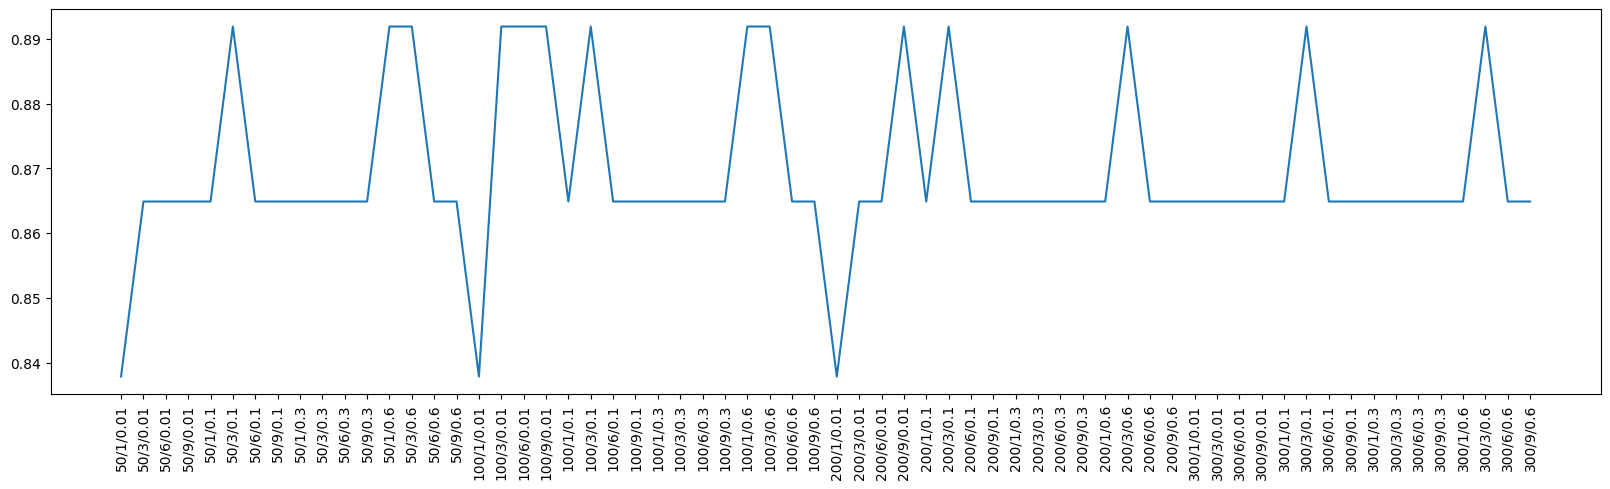

best_acc:0.8918918918918919
[300, 3, 0.6]


In [8]:
loca='LF'
raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_val.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)

X_train, y_train = augmented_trainset(data_train)

best_acc=0
progress=0
best_param=[]
pra_list=[]
acc_list=[]
for n_estimators in [50,100,200,300]:
    for learning_rate in [0.01, 0.1,0.3,0.6]:
        for max_depth in [1,3,6,9]:
            progress+=1
#             if progress%10==0:
#                 print(f'Progress:{progress}/{4*4*4}')
            xgb_clf = xgb.XGBClassifier(objective='binary:logistic', max_depth=max_depth,learning_rate=learning_rate,n_estimators=n_estimators)
            xgb_clf.fit(X_train, y_train)
        
            acc, _ = combine_predcict(xgb_clf,data_val)
            
            pra_list.append(f'{n_estimators}/{max_depth}/{learning_rate}')
            acc_list.append(acc)
            if acc >= best_acc:
                best_acc = acc
                best_param = [n_estimators,max_depth,learning_rate]
                
plt.figure(figsize=(20, 5))
plt.plot(pra_list, acc_list)
plt.xticks(rotation='vertical')
plt.show()
print(f'best_acc:{best_acc}')
print(best_param)

## LF  RandomSerach

In [9]:
from datetime import datetime
start_time = datetime.now()


raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
data_train = preprocess(raw_data_train)
X_train, y_train = augmented_trainset(data_train)

# search scope
param_dist = {
    'n_estimators': range(10, 250, 20),
    'learning_rate': [ 0.1, 0.2, 0.3, 0.4],
    'max_depth': range(1, 4),
    'colsample_bytree': [i/10.0 for i in range(2, 6)],
    'gamma': [i/10.0 for i in range(5)],
    'subsample': [i/10.0 for i in range(7, 9)],
    
    'reg_alpha': [0.001, 0.01, 0.1], #default 0
    'reg_lambda': [0.1, 1, 10],      #default 1
#     'early_stopping_rounds': [5, 10, 20, 30, 40]
}

# define model
xgboost_model = xgb.XGBClassifier()

# Initializaiton
random_search = RandomizedSearchCV(
    xgboost_model, 
    param_distributions=param_dist,
    n_iter=600,
    scoring='accuracy',
    n_jobs=-1,
    cv=5,
    verbose=1
)

# train
random_search.fit(X_train, y_train)

cv_results = pd.DataFrame(random_search.cv_results_)

#Print best parameters
print(random_search.best_params_)

# print training and testing scores
print(cv_results[['params', 'mean_test_score']])

print(cv_results.loc[cv_results['params']==random_search.best_params_, ['params','mean_test_score']])

# print(f'duration:{datetime.now()-start_time}')

best_para=''
for (key,value) in random_search.best_params_.items():
    best_para+=key+'='+str(value)+', '
print(best_para)


Fitting 5 folds for each of 600 candidates, totalling 3000 fits
{'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.001, 'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 0.4, 'colsample_bytree': 0.5}
                                                params  mean_test_score
0    {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alp...         0.877273
1    {'subsample': 0.8, 'reg_lambda': 10, 'reg_alph...         0.877273
2    {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...         0.868182
3    {'subsample': 0.7, 'reg_lambda': 10, 'reg_alph...         0.877273
4    {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alp...         0.881818
..                                                 ...              ...
595  {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha...         0.877273
596  {'subsample': 0.8, 'reg_lambda': 10, 'reg_alph...         0.872727
597  {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alp...         0.881818
598  {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alp...       

#### LF Some good paras

- RandomSearch
    - 0.9045  : subsample=0.8, reg_lambda=0.001, reg_alpha=1, n_estimators=210, max_depth=3, learning_rate=0.4, gamma=0.3, colsample_bytree=0.4
    
    - 0.9     : subsample=0.8, reg_lambda=1, reg_alpha=0.1, n_estimators=35, max_depth=3, learning_rate=0.2, gamma=0.3, colsample_bytree=0.1      

    - 0.9  : subsample=0.8, reg_lambda=0.1, reg_alpha=0.1, n_estimators=165, max_depth=4, learning_rate=0.3, gamma=0.3, colsample_bytree=0.2, 

    - 0.9  : subsample=0.9, reg_lambda=0.1, reg_alpha=0.01, n_estimators=145, max_depth=4, learning_rate=0.2, gamma=0.8, colsample_bytree=0.3
    
    - 0.9  : subsample=0.7, reg_lambda=0.1, reg_alpha=0.1, n_estimators=90, max_depth=1, learning_rate=0.2,  gamma=0.1, colsample_bytree=0.4
    
- Grid
    - [100,3,0.1]


## LF Learning Curve and Validation Performance

In [11]:
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

In [35]:

raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_val.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)

X_train, y_train = augmented_trainset(data_train)

# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', subsample=0.7, reg_lambda=0.1, reg_alpha=0.1, n_estimators=90, max_depth=1, learning_rate=0.2, gamma=0.1, colsample_bytree=0.4)
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1)

xgb_clf.fit(X_train, y_train)

acc, _ = combine_predcict(xgb_clf,data_val)
print(acc)

0.8918918918918919


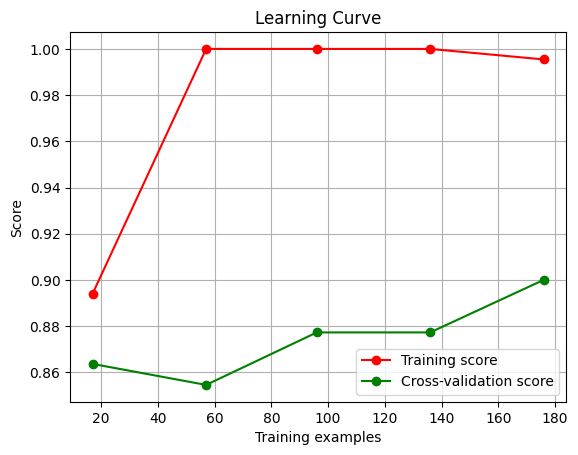

In [38]:


raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
data_train = preprocess(raw_data_train)
X_train, y_train = augmented_trainset(data_train)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', subsample=0.7, reg_lambda=0.1, reg_alpha=0.1, n_estimators=90, max_depth=1, learning_rate=0.2, gamma=0.1, colsample_bytree=0.4)
# xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=3, learning_rate=0.1)

plot_learning_curve(xgb_clf, X_train, y_train)
plt.show()        


## LF Final Score on VAL and TEST

In [39]:
raw_data_train = pd.read_csv('raw_data/'+loca+'_train.csv')
raw_data_val = pd.read_csv('raw_data/'+loca+'_val.csv')
raw_data_test = pd.read_csv('raw_data/'+loca+'_test.csv')

data_train = preprocess(raw_data_train)
data_val = preprocess(raw_data_val)
data_test = preprocess(raw_data_test)

X_train, y_train = augmented_trainset(data_train)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', subsample=0.7, reg_lambda=0.1, reg_alpha=0.1, n_estimators=90, max_depth=1, learning_rate=0.2, gamma=0.1, colsample_bytree=0.4)

xgb_clf.fit(X_train, y_train)

acc_val, _ = combine_predcict(xgb_clf,data_val)
acc_test, _ = combine_predcict(xgb_clf,data_test)
print(acc_val)
print(acc_test)

0.8918918918918919
0.918918918918919
